#### Install necessary libraries
%pip install scipy numpy keras tensorflow matplotlib

# Train Model

In [2]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

2022-01-27 12:46:13.887820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 12:46:13.887850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load images
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
        'images/',
        target_size=(252, 252),
        batch_size=2,
        class_mode=None)

Found 104 images belonging to 1 classes.


In [4]:
# Reshape images
train_images = train_generator.next()
train_images = train_images.reshape((252, 252, 3, -1))
train_images = train_images.transpose(3, 0, 1, 2)

In [5]:
# Create encoder model
input_img = Input(shape=(252, 252, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Create decoder model
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

2022-01-27 12:46:55.431352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-27 12:46:55.431389: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-27 12:46:55.431416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-01-27 12:46:55.431629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 252, 252, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 8)         584   

In [7]:
# Train autoencoder
autoencoder.fit(train_images, train_images, epochs=100, batch_size=20,verbose = 0)

In [8]:
# Save encoder model
encoder = Model(input_img, encoded)
encoder.save('encoder.h5')

# Use Model

In [3]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [154]:
# Now, for a given image, use the encoder model to produce embeddings
import os
embeddings_list = []
cyclone_names = []

# Load encoder model
from keras.models import load_model
encoder = load_model('encoder.h5')

# Load image
from keras.preprocessing.image import load_img
for file in os.listdir('images/image_dataset/'):
    if ".jpg" in file:
        image = load_img(f'images/image_dataset/{file}', target_size=(252, 252))

        # Reshape image
        image = np.array(image)
        image = image.reshape((252, 252, 3, -1))
        image = image.transpose(3, 0, 1, 2)

        # Produce embedding
        embedding = encoder.predict(image)
        embeddings_list.append(embedding)
        cyclone_names.append(file)

#print(embedding)

In [155]:
# Length of each embedding vector is 32
len(embedding[0])

32

In [156]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

01b Cyclone


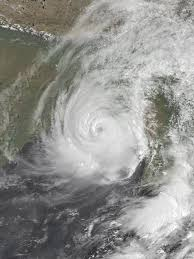

In [157]:
from IPython.display import Image
# Select appropriate file
print('01b Cyclone')
Image(filename= f"images/image_dataset/01b_2.jpg")

In [158]:
anchor_embedding = embeddings_list[0]
sims = []
for x in embeddings_list:
    sims.append(cosine_similarity(anchor_embedding.flatten(),x.flatten()))

In [159]:
top_k = cyclone_names[:]

In [160]:
new_sims = sims[:]
new_sims.sort(reverse=True)

In [161]:
new_sims[1:6]

[0.9707155, 0.9570878, 0.9564806, 0.9563422, 0.9562482]

### Compare Similarity

In [162]:
name_list = []
for x in new_sims[1:6]:
    name_list.append(top_k[sims.index(x)])

In [163]:
name_list

['queensland.jpg', 'madi.jpg', 'ita.jpg', 'nargis.jpg', 'z4.jpg']

Queensland Cyclone


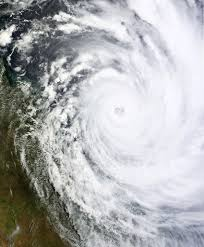

In [164]:
from IPython.display import Image
# select cyclone from returned list of similar responses
print(name_list[0].split('.')[0].capitalize() + " Cyclone")
Image(filename= f"images/image_dataset/{name_list[0]}")

# Cyclone Search and Compare

In [37]:
%pip install bs4 wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=32fee9dba0ca3f30c146d65ab2d48f606925ccb4d0574101212239d304b45b1b
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.


In [39]:
import wikipedia

In [165]:
def cyclone_details(cyclone_name):
    summary = wikipedia.summary(cyclone_name, sentences=10)
    search_result = wikipedia.page(cyclone_name)
    title = search_result.title
    content = search_result.content
    link = search_result.url
    
    print(title)
    print(f"Link: {link}\n")
    print("SUMMARY:")
    print(summary)
    print()
    print("Full Content:")
    print(content)
    return content

In [166]:
cyclone_details('01b')

Cyclone Nargis
Link: https://en.wikipedia.org/wiki/Cyclone_Nargis

SUMMARY:
Extremely Severe Cyclonic Storm Nargis (Urdu: نرگس [ˈnərɡɪs]) was an extremely destructive and deadly tropical cyclone that caused the worst natural disaster in the recorded history of Myanmar during early May 2008. The cyclone made landfall in Myanmar on Friday, 2 May 2008, sending a storm surge 40 kilometres up the densely populated Irrawaddy delta, causing catastrophic destruction and at least 138,373 fatalities. The Labutta Township alone was reported to have 80,000 dead, with about 10,000 more deaths in Bogale. There were around 55,000 people missing and many other deaths were found in other towns and areas, although the Myanmar government's official death toll may have been under-reported, and there have been allegations that government officials stopped updating the death toll after 138,000 to minimise political fallout. The feared 'second wave' of fatalities from disease and lack of relief efforts never

'Extremely Severe Cyclonic Storm Nargis (Urdu: نرگس [ˈnərɡɪs]) was an extremely destructive and deadly tropical cyclone that caused the worst natural disaster in the recorded history of Myanmar during early May 2008. The cyclone made landfall in Myanmar on Friday, 2 May 2008, sending a storm surge 40 kilometres up the densely populated Irrawaddy delta, causing catastrophic destruction and at least 138,373 fatalities. The Labutta Township alone was reported to have 80,000 dead, with about 10,000 more deaths in Bogale. There were around 55,000 people missing and many other deaths were found in other towns and areas, although the Myanmar government\'s official death toll may have been under-reported, and there have been allegations that government officials stopped updating the death toll after 138,000 to minimise political fallout. The feared \'second wave\' of fatalities from disease and lack of relief efforts never materialised. Damage was at $12 billion, making Nargis the costliest tr

In [170]:
 details = cyclone_details('Queensland Cyclone')

Cyclone Debbie
Link: https://en.wikipedia.org/wiki/Cyclone_Debbie

SUMMARY:
Severe Tropical Cyclone Debbie in 2017 was the strongest tropical cyclone to strike Queensland since Marcia in 2015, and was the costliest tropical cyclone in Australia since Yasi in 2011. Forming as a tropical low on 23 March, the low gradually intensified into a named tropical cyclone on 25 March. After steadily strengthening offshore to a Category 4 system, Debbie eventually made landfall near Airlie Beach, at 12:40 AEST on 28 March. Afterwards, Debbie rapidly weakened into a tropical low by late 28 March, but continued to travel south, causing significant damage and flooding in the populous areas of South East Queensland and Northern Rivers. In total, the storm caused A$3.5 billion (US$2.67 billion) in damage and fourteen deaths across Australia, primarily as a result of extreme flooding. This makes Debbie the deadliest cyclone to hit Australia since Fifi in 1991.


== Meteorological history ==

On 22 March

In [122]:
%pip install sentence-transformers

     |████████████████████████████████| 78 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 86.8 MB/s eta 0:00:01
     |█████████████▋                  | 375.8 MB 111.0 MB/s eta 0:00:05              | 194.9 MB 122.0 MB/s eta 0:00:06

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████▉       | 684.7 MB 82.0 MB/s eta 0:00:033

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 10 kB/s /s eta 0:00:01
     |████████████████████████████████| 23.2 MB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 26.4 MB 37.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 42.5 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=ea67f27614e41a3c07a0700da7b6a19346931a1b8295754b5bd80665814b18d6
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/17/1d/fd/a16123b417c527e0452c3e10ae5139cd2ab2f6fee93e892441
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [123]:
from sentence_transformers import SentenceTransformer, util

In [124]:
embedder =  SentenceTransformer('msmarco-distilbert-base-tas-b')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [128]:
# Store model for future use
import pickle
with open("sentence_model.pkl","wb") as pickle_file:
    pickle.dump(embedder, pickle_file)

In [130]:
# Load model if saved
with open("sentence_model.pkl","rb") as pickle_file:
    embedder = pickle.load(pickle_file)	

In [174]:
query = input()
query_embedding = embedder.encode(query)
passage = details.split('.')
passage_embeddings = embedder.encode(passage)
hits = util.semantic_search(query_embedding, passage_embeddings, top_k=5)
for hit in hits[0]:
    print(passage[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

 What steps were taken against it


 Attempts were made to evacuate residents from the island; however, ships were unable to dock as the jetty was destroyed (Score: 0.7038)
 Major damage was reported across Bowen, where most homes had been built before stricter building codes were enforced (Score: 0.6961)
 Approximately 5,500 people in the Bowen area were also urged to leave (Score: 0.6929)
26 billion), with 73,000 damage claims being filed (Score: 0.6821)
 Residents in low-lying areas across Bowen, Proserpine and Airlie Beach were ordered to evacuate their homes (Score: 0.6768)
